In [1]:
emails = read.csv("emails.csv", stringsAsFactors = FALSE)

In [2]:
nrow(emails)

[1] 5728

In [3]:
table(emails$spam)


   0    1 
4360 1368 

In [4]:
emails$text[1]

[1] "Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : your  marketing break - through shouldn ' t make gaps in your budget . 100 % satisfaction  guaranteed : we provide unlimited amount of changes with no extra fees for you to  be surethat you will love the result of this collaboration . have a look at our  portfolio _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ not interested . . . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _"

In [5]:
max(nchar(emails$text))

[1] 43952

In [6]:
which.min(nchar(emails$text))

[1] 1992

In [7]:
library(tm)
library(SnowballC)

Loading required package: NLP


In [8]:
corpus = VCorpus(VectorSource(emails$text))
corpus = tm_map(corpus, content_transformer(tolower))
corpus = tm_map(corpus, removePunctuation)
corpus = tm_map(corpus, removeWords, c(stopwords("english")))
corpus = tm_map(corpus, stemDocument)

In [9]:
dtm = DocumentTermMatrix(corpus)

In [10]:
dtm

<<DocumentTermMatrix (documents: 5728, terms: 28687)>>
Non-/sparse entries: 481719/163837417
Sparsity           : 100%
Maximal term length: 24
Weighting          : term frequency (tf)

In [11]:
spdtm = removeSparseTerms(dtm, 0.95)

In [12]:
spdtm

<<DocumentTermMatrix (documents: 5728, terms: 330)>>
Non-/sparse entries: 213551/1676689
Sparsity           : 89%
Maximal term length: 10
Weighting          : term frequency (tf)

In [13]:
emailsSparse = as.data.frame(as.matrix(spdtm))
colnames(emailsSparse) = make.names(colnames(emailsSparse))
which.max(colSums(emailsSparse))

enron 
   92

In [15]:
emailsSparse$spam = emails$spam

In [16]:
sum(colSums(subset(emailsSparse, spam == 0)) > 5000)

[1] 6

In [17]:
sum(colSums(subset(emailsSparse, spam == 1)) >= 1000) - 1

[1] 3

In [18]:
library(caTools)

emailsSparse$spam = as.factor(emailsSparse$spam)
set.seed(123)
split = sample.split(emailsSparse$spam, SplitRatio = 0.7)

train = subset(emailsSparse, split==TRUE)
test = subset(emailsSparse, split==FALSE)

In [19]:
spamLog = glm(spam ~., data = train, family = binomial)

Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [21]:
library(rpart)
library(rpart.plot)
spamCART = rpart(spam ~., data = train, method = "class")

In [24]:
library(randomForest)
set.seed(123)
spamRF = randomForest(spam ~., data = train)

In [26]:
predictLog = predict(spamLog)
predictCART = predict(spamCART)[,2]
predictRF = predict(spamRF, type="prob")[,2]

In [27]:
sum(predictLog < 0.00001)
sum(predictLog > 0.99999)
sum(predictLog < 0.99999 && predictLog > 0.00001)

[1] 3056

[1] 954

[1] 0

In [28]:
nrow(train)

[1] 4010

In [30]:
summary(spamLog)


Call:
glm(formula = spam ~ ., family = binomial, data = train)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.011   0.000   0.000   0.000   1.354  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)
(Intercept) -3.082e+01  1.055e+04  -0.003    0.998
X000         1.474e+01  1.058e+04   0.001    0.999
X2000       -3.631e+01  1.556e+04  -0.002    0.998
X2001       -3.215e+01  1.318e+04  -0.002    0.998
X713        -2.427e+01  2.914e+04  -0.001    0.999
X853        -1.212e+00  5.942e+04   0.000    1.000
abl         -2.049e+00  2.088e+04   0.000    1.000
access      -1.480e+01  1.335e+04  -0.001    0.999
account      2.488e+01  8.165e+03   0.003    0.998
addit        1.463e+00  2.703e+04   0.000    1.000
address     -4.613e+00  1.113e+04   0.000    1.000
allow        1.899e+01  6.436e+03   0.003    0.998
alreadi     -2.407e+01  3.319e+04  -0.001    0.999
also         2.990e+01  1.378e+04   0.002    0.998
analysi     -2.405e+01  3.860e+04  -0.001    1.000
a

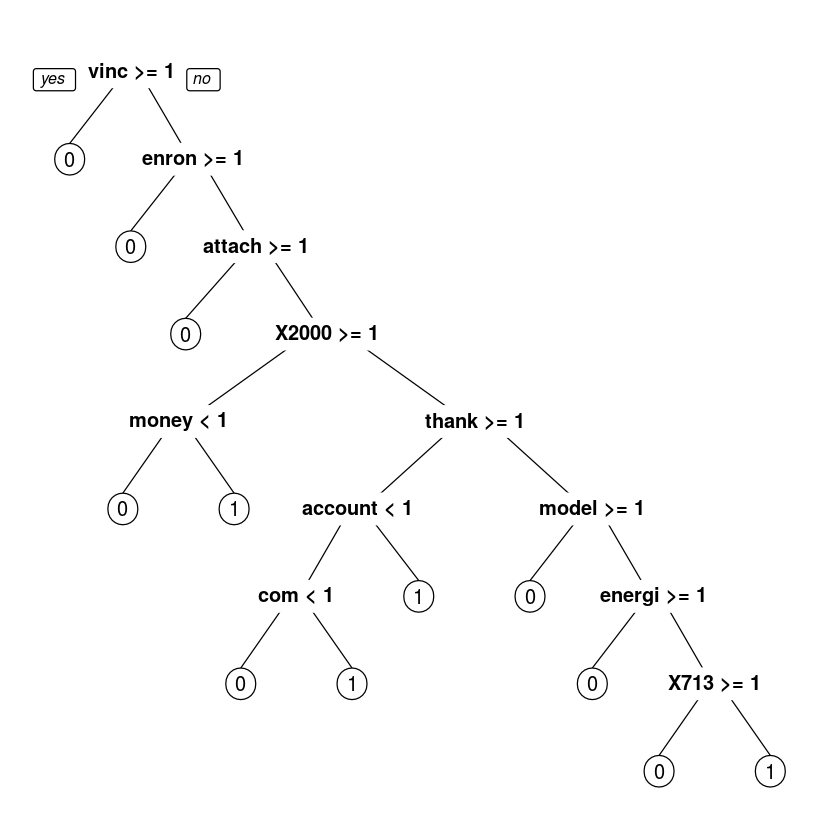

In [31]:
prp(spamCART)

In [34]:
table(predictLog > 0.5, train$spam)

       
           0    1
  FALSE 3052    4
  TRUE     0  954

In [36]:
(3052 + 954) / nrow(train)

[1] 0.9990025

In [37]:
library(ROCR)
as.numeric(performance(prediction(predictLog, train$spam), 'auc')@y.values)

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



[1] 0.9999959

In [38]:
table(predictCART > 0.5, train$spam)
as.numeric(performance(prediction(predictCART, train$spam), 'auc')@y.values)

       
           0    1
  FALSE 2885   64
  TRUE   167  894

[1] 0.9696044

In [39]:
(2885 + 894) / nrow(train)

[1] 0.942394

In [40]:
table(predictRF > 0.5, train$spam)
as.numeric(performance(prediction(predictRF, train$spam), 'auc')@y.values)

       
           0    1
  FALSE 3015   42
  TRUE    37  916

[1] 0.9978155

In [41]:
(3015 + 916) / nrow(train)

[1] 0.9802993

In [42]:
predictLog = predict(spamLog, newdata = test)
predictCART = predict(spamCART, newdata = test)[,2]
predictRF = predict(spamRF, type="prob", newdata = test)[,2]

In [43]:
table(predictLog > 0.5, test$spam)
as.numeric(performance(prediction(predictLog, test$spam), 'auc')@y.values)
table(predictCART > 0.5, test$spam)
as.numeric(performance(prediction(predictCART, test$spam), 'auc')@y.values)
table(predictRF > 0.5, test$spam)
as.numeric(performance(prediction(predictRF, test$spam), 'auc')@y.values)

       
           0    1
  FALSE 1258   34
  TRUE    50  376

[1] 0.9767994

       
           0    1
  FALSE 1228   24
  TRUE    80  386

[1] 0.963176

       
           0    1
  FALSE 1291   23
  TRUE    17  387

[1] 0.9975899

In [45]:
(1258 + 376) / nrow(test)
(1228 + 386) / nrow(test)
(1291 + 387) / nrow(test)

[1] 0.9511059

[1] 0.9394645

[1] 0.9767171